In [1098]:
import os

In [1099]:
%pwd

'C:\\Users\\RICH-FILES\\Desktop\\ml\\Loan-Amount-Prediction'

In [1100]:
os.chdir("../")

In [1101]:
%pwd

'C:\\Users\\RICH-FILES\\Desktop\\ml'

In [1102]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class DataTransformationConfig:
    root_dir: Path
    data_path: Path
    

In [1103]:
#import from constants and utils
from credit_risk.constants import *
from credit_risk.utils.common import read_yaml, create_directories

In [1104]:

#creating a Configuration class
class ConfigurationManager:
    def __init__(
        self,
        config_filepath   = CONFIG_FILE_PATH,
        params_filepath   = PARAMS_FILE_PATH,
        schema_filepath   = SCHEMA_FILE_PATH):
        
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)                       
        self.schema = read_yaml(schema_filepath)  
        
        create_directories([self.config.artifacts_root])
        
    def get_data_transformation_config(self)->DataTransformationConfig:
        config = self.config.data_transformation
        
        create_directories([config.root_dir])
        
        data_transformation_config = DataTransformationConfig(
            root_dir  = config.root_dir,
            data_path = config.data_path,
        )
        
        return data_transformation_config
    
       

In [1105]:
import os
import pandas as pd 
from sklearn.model_selection import train_test_split
from credit_risk import logger
import matplotlib.pyplot as plt
import seaborn as sns   


In [1106]:
class DataTransformation:
    def __init__(self, config: DataTransformationConfig):
        self.config = config
       

In [1107]:
project_path = "C:/Users/RICH-FILES/Desktop/ml/Loan-Amount-Prediction"

os.chdir(project_path)

In [1108]:
# add EDA to the data 
#df = pd.read_csv("artifacts/data_ingestion/credit_risk.csv")
#df.head()

In [1109]:
#df.shape

In [1110]:
#df.info()

In [1111]:
#df.isnull().sum()

In [1112]:
#drop the missing values
#df = df.dropna()

In [ ]:
#check missing values
#df.isnull().sum()


Age               0
Income            0
Home              0
Emp_length        0
Intent            0
Amount            0
Rate              0
Percent_income    0
dtype: int64

In [1114]:
#check descriptive statistics
#df.describe()

In [1115]:
#check non numeric columns
#df.describe(include='object')


Most of the homes are rented and the most of the loans are intented for educational purposes

In [1116]:
#check the target variable
#df['Amount'].hist()
#plt.ylabel('Count')
#plt.xlabel('Amount')    
#plt.title('Loan Amount Distribution');

The distribution is right-skewed, meaning most loan amounts fall in the lower range (below 10,000), while fewer loans exist at higher amounts

In [1117]:
#calculate Amount distribution by Age   
#plt.figure(figsize=(12,6))
#sns.scatterplot(x='Age', y='Amount', data=df) 
#plt.xlabel('Age')
#plt.ylabel('Amount')            
#plt.title('Loan Amount by Age');      

Most of the loan applicants are between the age 23 to 45 years and there are three outliers above 100 years 

In [1118]:
# calculating Amount distribution by Income
#plt.figure(figsize=(12,6))
#sns.scatterplot(x='Income', y='Amount', data=df)    
#plt.xlabel('Income')
#plt.ylabel('Amount')
#plt.title('Loan Amount by Income');


- most of the income values are concentrated on the left side (closer to zero).

- A few extreme outliers have very high incomes (above $1M)

- Loan amounts do not seem to increase proportionally with income, even those with high income are taking loans of varying amounts



In [1119]:
   #loan purpose count
#plt.figure(figsize=(12,6))
#df["Intent"].value_counts().plot(kind='bar')
#plt.ylabel('Count')
#plt.xlabel('Intent')
#plt.title('Loan Intent Distribution');   

Most of the loan applications are going towards education followed by medical, venture, personal, debtconsolidation and the least number of applications are for homeimprovements.

In [1120]:
#check multicollinearity and correlation
#plt.figure(figsize=(12,6))  
#corr = df.select_dtypes(include=['int64', 'float64']).drop('Amount', axis=1).corr()    
#sns.heatmap(corr, annot=True, cmap='coolwarm')
#plt.title('Correlation Matrix');


There is a strong correlatedness between Age and Cred_length

In [1121]:
#drop column Id and Cred_length , Status, Default   
#columns_to_drop = ["Id", "Cred_length", "Status", "Default"]
#df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)
#pd.options.mode.copy_on_write=True
#df.head()

In [1122]:
#feature engineering
#cat_features    = df[["Home", "Intent"]]
#num_features   = df[["Age",	"Income", "Emp_length", "Amount",	"Rate", 	"Percent_income"]]



In [1123]:
#transform categorical data and stardardize the data
#from sklearn.preprocessing import StandardScaler
#from sklearn.compose import ColumnTransformer
#from sklearn.pipeline import Pipeline   
#from sklearn.pipeline import make_pipeline
#from sklearn.preprocessing import OneHotEncoder

In [1124]:
# instantiate the column StandardScaler
#numerical_processor = Pipeline(
    #steps =[("standard scaling",  StandardScaler()
    #)]  
#)
        
                 


In [1125]:
# instantiate the column OneHotEncoder
#categorical_processor = Pipeline(
    #steps =[("one hot encoding", OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    #)]  
#)


In [1126]:
#implement the column transformer
#preprocessor = ColumnTransformer(
    #transformers=[
        #("numerical", numerical_processor, num_features.columns),
        #("categorical", categorical_processor, cat_features.columns)
    #]
#)   
 

In [1127]:
#fit the preprocessor
#preprocessor.fit(df)

In [1128]:
#transform the data
#transformed_data=preprocessor.transform(df)  

#data=pd.DataFrame(transformed_data)
#data.columns = num_features.columns.tolist() + preprocessor.named_transformers_["categorical"]["one hot encoding"].get_feature_names_out().tolist()
#data.to_csv("artifacts/data_ingestion/credit_risk.csv", index=False)     

#data.head()

In [ ]:
class DataTransformation:
    def __init__(self, config: DataTransformationConfig):
        self.config = config
        
        project_path = "C:/Users/RICH-FILES/Desktop/ml/Loan-Amount-Prediction"

        os.chdir(project_path)
        
        # add EDA to the data 
        df = pd.read_csv("artifacts/data_ingestion/credit_risk.csv")
        df.head()
        
        df.shape
        
        df.info()
        
        df.isnull().sum()
        
        #drop the missing values
        df = df.dropna()
        
        #check missing values
        df.isnull().sum()
        
        #check descriptive statistics
        df.describe()
        
        #check non numeric columns
        #df.describe(include='object')
        
        #check the target variable
        df['Amount'].hist()
        plt.ylabel('Count')
        plt.xlabel('Amount')    
        plt.title('Loan Amount Distribution');
        #The distribution is right-skewed, meaning most loan amounts fall in the lower range (below 10,000), while fewer loans exist at higher amounts
        
        #calculate Amount distribution by Age   
        plt.figure(figsize=(12,6))
        sns.scatterplot(x='Age', y='Amount', data=df) 
        plt.xlabel('Age')
        plt.ylabel('Amount')            
        plt.title('Loan Amount by Age');    
        #Most of the loan applicants are between the age 23 to 45 years and there are three outliers above 100 years 
        
        # calculating Amount distribution by Income
        plt.figure(figsize=(12,6))
        sns.scatterplot(x='Income', y='Amount', data=df)    
        plt.xlabel('Income')
        plt.ylabel('Amount')
        plt.title('Loan Amount by Income');
        
        
        # most of the income values are concentrated on the left side (closer to zero).

        # A few extreme outliers have very high incomes (above $1M)

        # Loan amounts do not seem to increase proportionally with income, even those with high income are taking loans of varying amounts
                
        #loan purpose count
        plt.figure(figsize=(12,6))
        df['Intent'].value_counts().plot(kind='bar')
        plt.ylabel('Count')
        plt.xlabel('Intent')
        plt.title('Loan Intent Distribution'); 
        #Most of the loan applications are going towards education followed by medical, venture, personal, debt consolidation and the least number of applications are for homeimprovements.
        
        
        #check multi collinearity and correlation
        plt.figure(figsize=(12,6))  
        corr = df.select_dtypes(include=['int64', 'float64']).drop('Amount', axis=1).corr()    
        sns.heatmap(corr, annot=True, cmap='coolwarm')
        plt.title('Correlation Matrix');
        #There is a strong correlatedness between Age and Cred_length
        
        #drop column Id and Cred_length , Status, Default   
        columns_to_drop = ["Id", "Cred_length", "Status", "Default"]
        df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)
        pd.options.mode.copy_on_write=True
        df.head()
        
        #feature engineering
        cat_features    = df[["Home", "Intent"]]
        num_features   = df[["Age",	"Income", "Emp_length", "Amount",	"Rate", 	"Percent_income"]]
        
        #transform categorical data and stardardize the data
        from sklearn.preprocessing import StandardScaler
        from sklearn.compose import ColumnTransformer
        from sklearn.pipeline import Pipeline   
        from sklearn.pipeline import make_pipeline
        from sklearn.preprocessing import OneHotEncoder
        
        # instantiate the column StandardScaler
        numerical_processor = Pipeline(
            steps =[("standard scaling",  StandardScaler()
            )]  
        )
        
        # instantiate the column OneHotEncoder
        categorical_processor = Pipeline(
            steps =[("one hot encoding", OneHotEncoder(handle_unknown='ignore', sparse_output=False)
            )]  
        )  
        
        #implement the column transformer
        preprocessor = ColumnTransformer(
            transformers=[
                ("numerical", numerical_processor, num_features.columns),
                ("categorical", categorical_processor, cat_features.columns)
            ]
        )   
        
        #fit the preprocessor
        preprocessor.fit(df)
        
        #transform the data
        transformed_data=preprocessor.transform(df)  

        data=pd.DataFrame(transformed_data)
        data.columns = num_features.columns.tolist() + preprocessor.named_transformers_["categorical"]["one hot encoding"].get_feature_names_out().tolist()
        data.to_csv("artifacts/data_ingestion/credit_risk.csv", index=False)     

        data.head()
            
    def train_test_splitting(self):
        data = pd.read_csv(self.config.data_path)
        
        #split the data into train and test
        train, test = train_test_split(data, test_size=0.2, random_state=42)  
        
        train.to_csv(os.path.join(self.config.root_dir, 'train.csv'), index=False)
        test.to_csv(os.path.join(self.config.root_dir, 'test.csv'), index=False)        #save the train and test data to the root directory     
        
        logger.info("Data split into train and test data")  
        logger.info(f"Train data shape: {train.shape}")         
        logger.info(f"Test data shape: {test.shape}")  
        
        print(train.shape)
        print(test.shape)                
    


[2025-03-04 15:56:03,495: INFO: common: yaml file: config\config.yaml loaded successfully]
[2025-03-04 15:56:03,497: INFO: common: yaml file: params.yaml loaded successfully]
[2025-03-04 15:56:03,502: INFO: common: yaml file: schema.yaml loaded successfully]
[2025-03-04 15:56:03,504: INFO: common: created directory at: artifacts]
[2025-03-04 15:56:03,506: INFO: common: created directory at: artifacts/data_transformation]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              32581 non-null  int64  
 1   Age             32581 non-null  int64  
 2   Income          32581 non-null  int64  
 3   Home            32581 non-null  object 
 4   Emp_length      31686 non-null  float64
 5   Intent          32581 non-null  object 
 6   Amount          32581 non-null  int64  
 7   Rate            29465 non-null  float64
 8   Status     

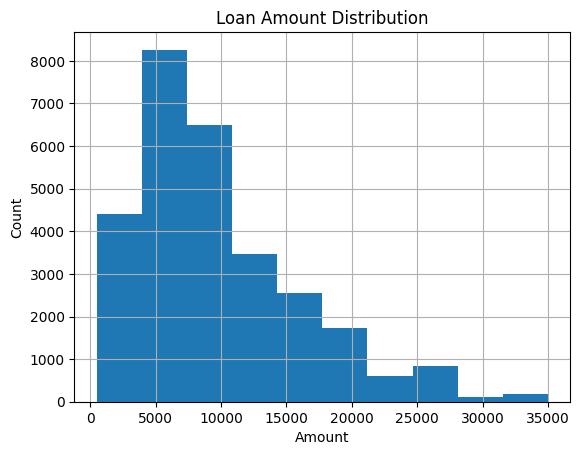

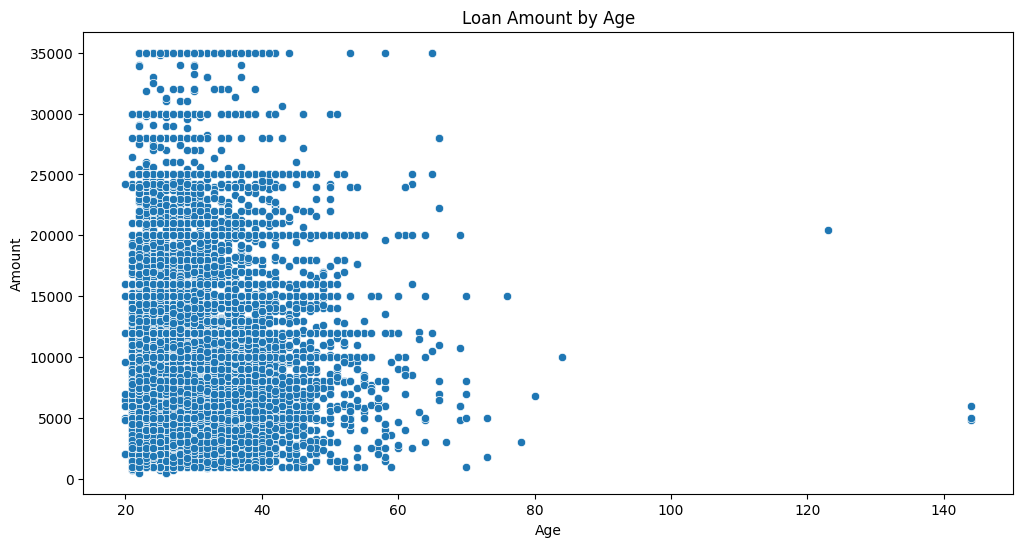

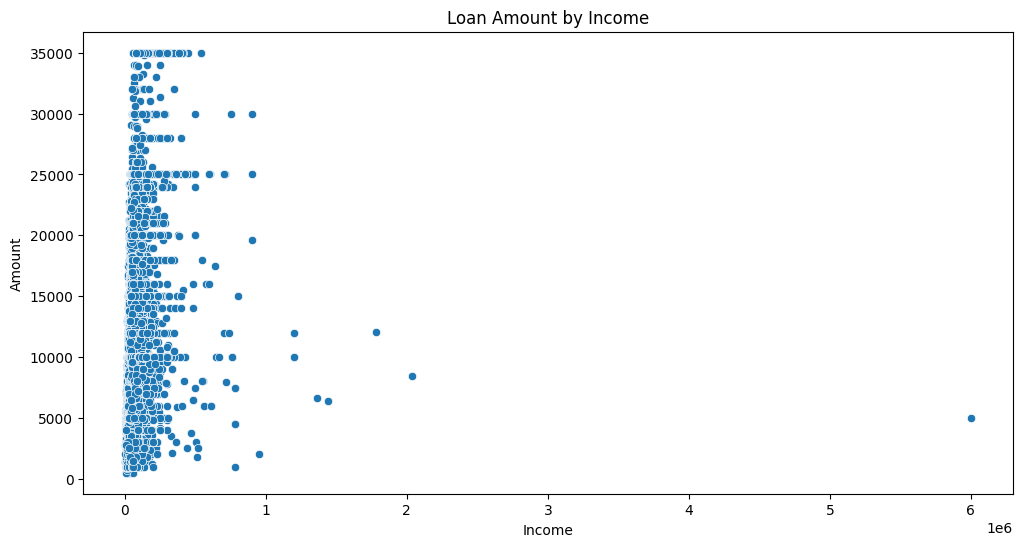

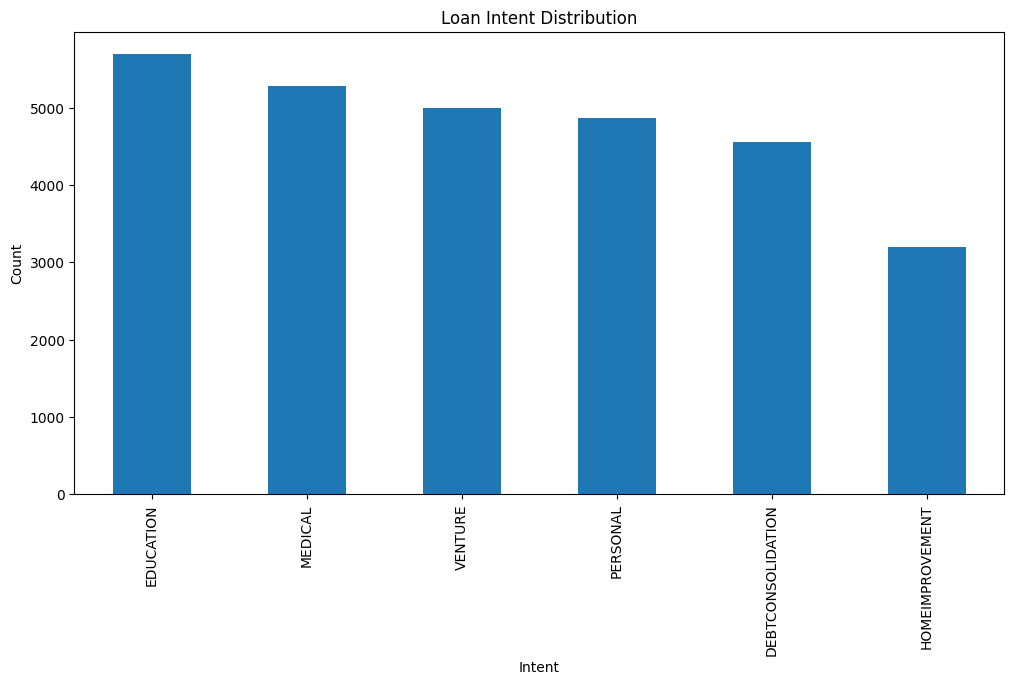

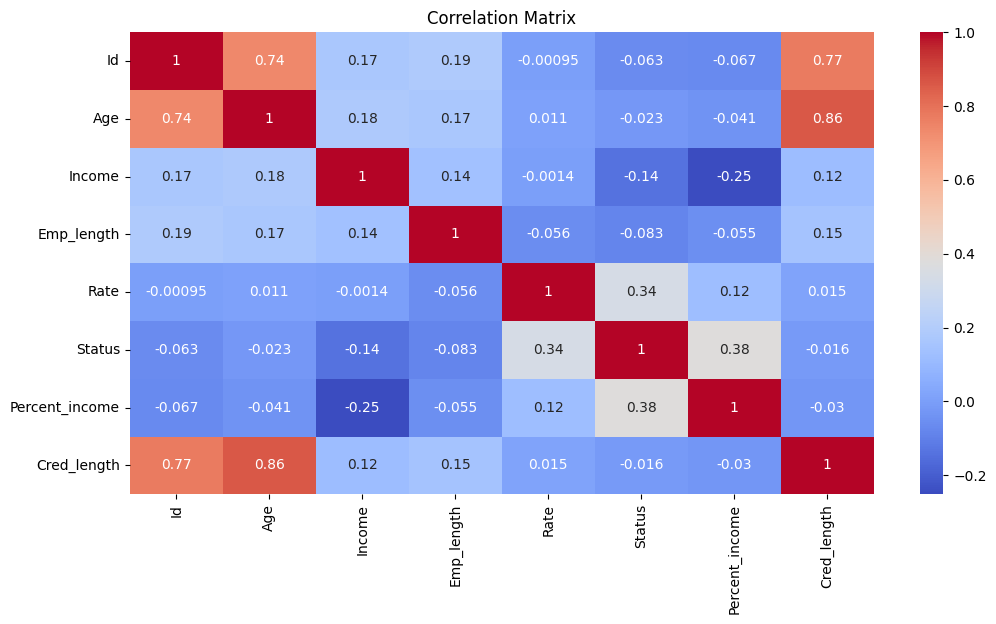

In [1130]:
try:
    config = ConfigurationManager()
    data_transformation_config = config.get_data_transformation_config() 
    data_transformation = DataTransformation(config = data_transformation_config)
    data_transformation.train_test_splitting()
except Exception as e:
    raise e